# Constrained Active Learning - Experiment on the ANIMALS problem

#### Importing libraries

In [1]:
#%matplotlib inline
#%autosave 10
import os
import random
from datetime import datetime

import torchvision
import matplotlib.animation
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from torch.utils.data import DataLoader
from torchvision.transforms import transforms
from tqdm import trange
from active_learn_strategy import SUPERVISED, CAL, UNCERTAIN, RANDOM, supervised_selection, random_selection, \
	cal_selection, uncertainty_selection, \
	uncertainty_loss
from constraint_loss import winston_loss
from data.Animals import CLASS_1_HOTS
from metrics import F1

plt.rc('animation', html='jshtml')

dataset = "animals"
model_folder = os.path.join("models", dataset)
result_folder = os.path.join("results", dataset)
image_folder = os.path.join("images", dataset)
if not os.path.isdir(model_folder):
	os.makedirs(model_folder)
if not os.path.isdir(result_folder):
	os.makedirs(result_folder)
if not os.path.isdir(image_folder):
	os.makedirs(image_folder)
np.random.seed(0)
torch.manual_seed(0)
random.seed(0)
dev = "cuda:1" if torch.cuda.is_available() else "cpu"
sns.set_theme(style="whitegrid", font="Times New Roman")

#### Loading data for the animal's problem.
Data pass through a RESNET 50 first which extract the data features

In [3]:
first_points = 100
n_points = 50
n_iterations = 58
seeds = range(5)
epochs = 1000
num_classes = 33
main_classes = 7
metric = F1()
# metric = MultiLabelAccuracy(num_classes)

transform = transforms.Compose([
	transforms.Resize(256),
	transforms.CenterCrop(224),
	transforms.ToTensor(),
	transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
dataset = torchvision.datasets.ImageFolder("data/Animals", transform=transform)
feature_extractor = torchvision.models.resnet50(pretrained=True)
feature_extractor.fc = torch.nn.Identity()
data_loader = DataLoader(dataset, batch_size=128, num_workers=8)
tot_points = len(dataset)

In [4]:
load = True
feature_file = "data/Animals/ResNet50-TL-feats.pth"
if os.path.isfile(feature_file) and load:
	x = torch.load(feature_file)
	y = dataset.targets
	y_multi = [CLASS_1_HOTS[dataset.classes[t]] for t in dataset.targets]
	print("Features loaded")
else:
	x, y = [], []
	with torch.no_grad():
		feature_extractor.eval(), feature_extractor.to(dev)
		for i, (batch_data, batch_labels) in enumerate(data_loader):
			print(f"{i}/{len(data_loader)} it, time: {datetime.now()}")
			batch_x = feature_extractor(batch_data.to(dev))
			x.append(batch_x)
			y.append(batch_labels)
		x = torch.cat(x)
		y = torch.cat(y)
		y_multi = [CLASS_1_HOTS[dataset.classes[t]] for t in dataset.targets]
		torch.save(x, feature_file)
input_size = x.shape[1]


Features loaded


#### Defining constraints as product t-norm of the FOL rule expressing by the Winston knowledge

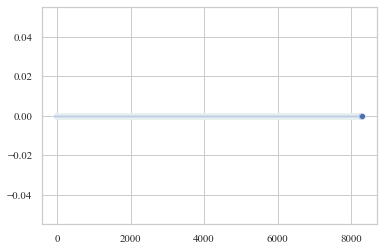

In [6]:
def calculate_constraint_loss(f: torch.Tensor, reduce_sum=False) -> torch.Tensor:
	c_loss = winston_loss(f, sum=reduce_sum)
	return c_loss


x_t = torch.as_tensor(x, dtype=torch.float).to(dev)
y_multi_t = torch.as_tensor(y_multi, dtype=torch.float).to(dev)
cons_loss = calculate_constraint_loss(y_multi_t).sort()[0].cpu().numpy()
sns.scatterplot(x=[*range(len(cons_loss))], y=cons_loss)
plt.show()


#### Creating a simple MLP

In [9]:
class MLP(torch.nn.Module):
	def __init__(self, i_size, h_size, n_classes):
		super(MLP, self).__init__()
		self.input_size = i_size
		self.hidden_size = h_size
		self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size)
		self.relu = torch.nn.LeakyReLU()
		self.fc2 = torch.nn.Linear(self.hidden_size, n_classes)
		self.sigmoid = torch.nn.Sigmoid()

	def forward(self, input_x: torch.Tensor):
		hidden = self.fc1(input_x)
		relu = self.relu(hidden)
		output = self.fc2(relu)
		output = self.sigmoid(output)
		return output


#### Checking outputs before training

In [10]:
def visualize_data_predictions(net: MLP, data: torch.Tensor, labels: torch.Tensor,
                               idx: list = None) -> float:
	with torch.no_grad():
		p_t = net(data).squeeze()
	p_main = p_t[:, :main_classes].argmax(dim=1).cpu()
	c_loss = calculate_constraint_loss(p_t).cpu()
	s_loss = torch.nn.BCELoss(reduction="none")(p_t, labels).sum(dim=1).cpu()
	if idx is None:
		u_idx = np.asarray([*range(data.shape[0])])
	else:
		u_idx = np.zeros_like(s_loss)
		u_idx[idx] = 1
	sns.scatterplot(x=c_loss, y=s_loss, hue=p_main, style=u_idx)
	plt.title("Supervision vs Constraint Loss")
	plt.show()
	acc = metric(p_t, labels)
	print(f"Accuracy: {acc}, Sup loss: {s_loss.mean().item()}")
	return acc


#### Few epochs with n randomly selected data

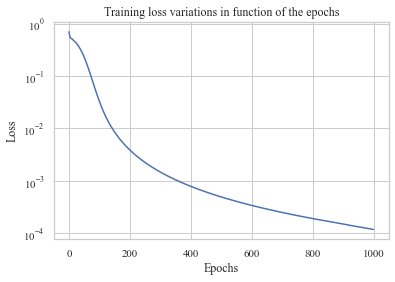

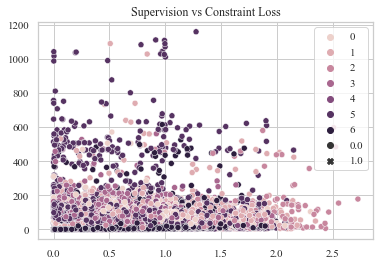

Accuracy: 26.66992464821764, Sup loss: 79.8517837524414


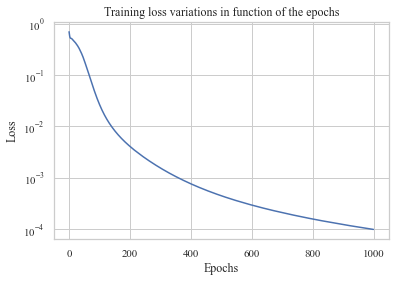

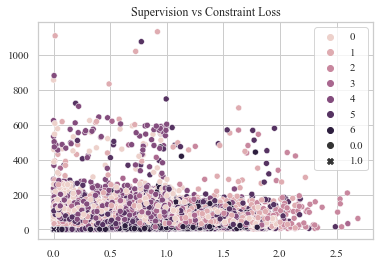

Accuracy: 26.554486379030013, Sup loss: 72.70286560058594


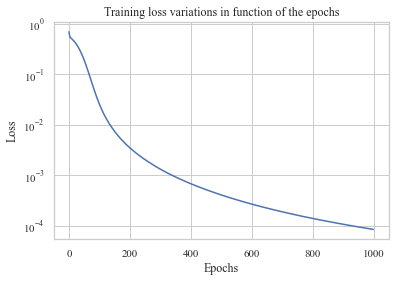

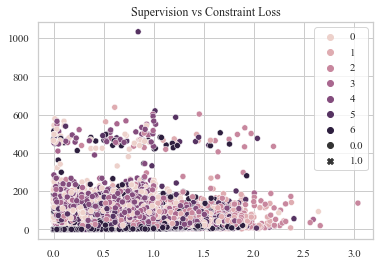

Accuracy: 26.48164212632703, Sup loss: 69.58065032958984


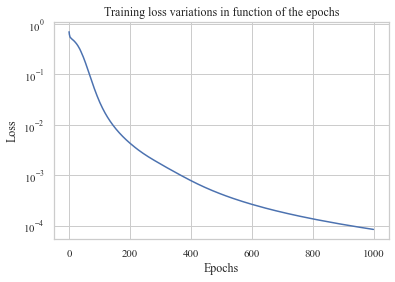

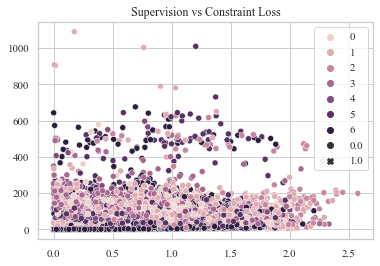

Accuracy: 27.79111843287336, Sup loss: 74.95527648925781


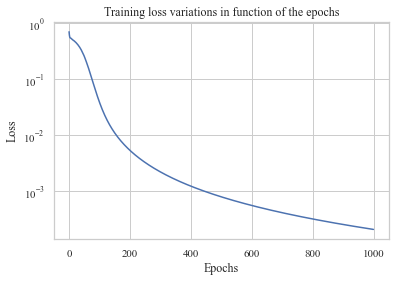

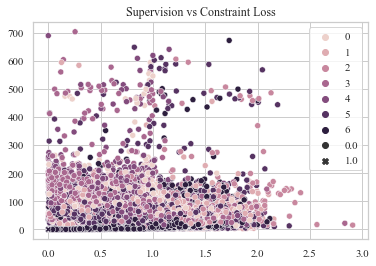

Accuracy: 28.19283656964226, Sup loss: 67.1671371459961


In [11]:
def train_loop(net: MLP, train_data: torch.Tensor, train_labels: torch.Tensor,
               train_idx: list, e, visualize_loss: bool = False):
	train_idx = np.asarray(train_idx)
	train_data = train_data[train_idx, :]
	train_labels = train_labels[train_idx].squeeze()
	optim = torch.optim.AdamW(net.parameters())
	loss = torch.nn.BCELoss()
	l_train = []
	for j in range(e):
		optim.zero_grad()
		p_t = net(train_data).squeeze()
		s_l = loss(p_t, train_labels)
		s_l.backward()
		optim.step()
		l_train.append(s_l.item())
	if visualize_loss:
		sns.lineplot(data=l_train)
		plt.ylabel("Loss"), plt.xlabel("Epochs"), plt.yscale("log")
		plt.title("Training loss variations in function of the epochs")
		plt.show()
	return l_train


first_idx = []
first_loss = []
first_acc = []
for seed in seeds:
	network = MLP(input_size, 100, num_classes).to(dev)
	first_idx.append([])
	first_idx[seed] += np.random.randint(0, x.shape[0] - 1, first_points).tolist()
	first_loss.append(train_loop(network, x_t, y_multi_t, first_idx[seed], epochs, visualize_loss=True))
	first_acc.append(visualize_data_predictions(network, x_t, y_multi_t, first_idx[seed]))
	torch.save(network, os.path.join(model_folder, f"first_train_{seed}.pt"))

In [ ]:
strategies = [RANDOM, SUPERVISED, CAL, UNCERTAIN]
selection_fun = {
	SUPERVISED: supervised_selection,
	RANDOM: random_selection,
	CAL: cal_selection,
	UNCERTAIN: uncertainty_selection,
}
df = {
	"strategy": [],
	"seed": [],
	"iteration": [],
	"active_idx": [],
	"used_idx": [],
	"predictions": [],
	"accuracy": [],
	"supervision_loss": [],
	"constraint_loss": [],
	"uncertainty_loss": []
}
for seed in seeds:

	for strategy in strategies:
		# Loading weights saved after first training
		network = torch.load(os.path.join(model_folder, f"first_train_{seed}.pt")).to(dev)
		with torch.no_grad():
			preds_t = network(x_t).squeeze()
		accuracy = metric(preds_t, y_multi_t)
		assert first_acc[seed] == accuracy, "Error in loading the network"
		cons_loss = calculate_constraint_loss(preds_t)
		sup_loss = torch.nn.BCELoss(reduction="none")(preds_t, y_multi_t).sum(dim=1)
		unc_loss = uncertainty_loss(preds_t)

		active_accuracies = [accuracy]
		available_idx = [*range(tot_points)]
		used_idx: list = first_idx[seed].copy()

		df["strategy"].append(strategy)
		df["seed"].append(seed)
		df["iteration"].append(0)
		df["active_idx"].append(used_idx.copy())
		df["used_idx"].append(used_idx.copy())
		df["predictions"].append(preds_t.cpu().numpy())
		df["accuracy"].append(accuracy)
		df["constraint_loss"].append(cons_loss.cpu().numpy())
		df["supervision_loss"].append(sup_loss.cpu().numpy())
		df["uncertainty_loss"].append(unc_loss.cpu().numpy())

		losses = first_loss[seed].copy()
		pbar = trange(n_iterations, ncols=100)
		for n in range(1, n_iterations + 1):
			available_idx = list(set(available_idx) - set(used_idx))

			if strategy == SUPERVISED:
				active_idx = supervised_selection(used_idx, sup_loss, n_points)
			elif strategy == CAL:
				active_idx = cal_selection(used_idx, cons_loss, n_points)
			elif strategy == UNCERTAIN:
				active_idx = uncertainty_selection(used_idx, unc_loss, n_points)
			else:
				active_idx = random_selection(available_idx, n_points)
			used_idx += active_idx

			losses += train_loop(network, x_t, y_multi_t, used_idx, epochs)

			with torch.no_grad():
				preds_t = network(x_t).squeeze()
			accuracy = metric(preds_t, y_multi_t)
			cons_loss = calculate_constraint_loss(preds_t)
			sup_loss = torch.nn.BCELoss(reduction="none")(preds_t, y_multi_t).sum(dim=1)
			unc_loss = uncertainty_loss(preds_t)

			df["strategy"].append(strategy)
			df["seed"].append(seed)
			df["iteration"].append(n)
			df["active_idx"].append(active_idx.copy())
			df["used_idx"].append(used_idx.copy())
			df["predictions"].append(preds_t.cpu().numpy())
			df["accuracy"].append(accuracy)
			df["constraint_loss"].append(cons_loss.cpu().numpy())
			df["supervision_loss"].append(sup_loss.cpu().numpy())
			df["uncertainty_loss"].append(unc_loss.cpu().numpy())
			pbar.set_description(f"Seed: {seed}/{len(seeds)}, Strategy: {strategy}, "
			                     f"Acc: {accuracy:.1f}, S loss: {sup_loss.mean().item():.2f}, n p: {len(used_idx)}")
			pbar.update()

		pbar.close()
		if seed == 0:
			sns.lineplot(data=losses)
			plt.yscale("log")
			plt.ylabel("Loss")
			plt.xlabel("Epochs")
			plt.title(f"Training loss variations for {strategy} active learning strategy")
			plt.show()

df = pd.DataFrame(df)
df.to_pickle(os.path.join(result_folder, f"metrics_{n_points}_points.pkl"))

In [ ]:
np.asarray(used_idx)

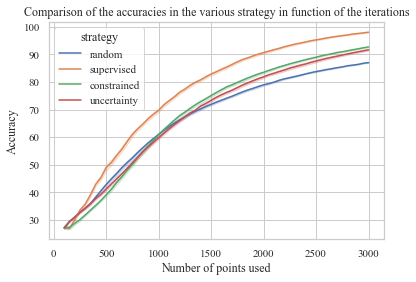

In [4]:
df = pd.read_pickle(os.path.join(result_folder, f"metrics_{n_points}_points.pkl"))
df['n_points'] = [len(used) for used in df['used_idx']]
sns.lineplot(data=df, x="n_points", y="accuracy", hue="strategy", ci=75)
plt.ylabel("Accuracy")
plt.xlabel("Number of points used")
plt.title("Comparison of the accuracies in the various strategy in function of the iterations")
plt.savefig(os.path.join(image_folder, f"Accuracy_{n_points}_points.png"))
plt.show()


#### Create animation to visualize training

In [ ]:
def animate_points_and_prediction(i, active_strategy, dataframe):
	print(i)
	dataframe = dataframe[dataframe["seed"] == 0]
	df_strategy = dataframe[dataframe["strategy"] == active_strategy].reset_index()
	if i != len(df_strategy["active_idx"]):
		a_idx = df_strategy["active_idx"][i]
		u_idx = df_strategy["used_idx"][i]
	else:
		a_idx = []
		u_idx = df_strategy["used_idx"][i - 1]
	new_idx = [1 if idx in a_idx else 0 for idx in u_idx]
	x0, x1 = x[:, 0], x[:, 1]
	if i == 0:
		preds = df_strategy["predictions"][i]
	else:
		preds = df_strategy["predictions"][i - 1]
	sns.scatterplot(x=x0, y=x1, hue=preds, legend=False)
	sns.scatterplot(x=x0[np.asarray(u_idx)], y=x1[np.asarray(u_idx)],
	                hue=new_idx, legend=False)
	plt.axhline(0.5, 0, 1, c="k")
	plt.axvline(0.5, 0, 1, c="k")
	plt.title(f"Selected data points for {strategy} training, iter {i}")


def animate_cons_loss(i, active_strategy, dataframe):
	df_strategy = dataframe[dataframe["strategy"] == active_strategy].reset_index()
	cons_loss = df_strategy["constraint_loss"][i]
	x0, x1 = x[:, 0], x[:, 1]
	sns.scatterplot(x=x0, y=x1, hue=cons_loss, legend=False)


def animate_sup_loss(i, active_strategy, dataframe):
	df_strategy = dataframe[dataframe["strategy"] == active_strategy].reset_index()
	sup_loss = df_strategy["supervision_loss"][i]
	x0, x1 = x[:, 0], x[:, 1]
	sns.scatterplot(x=x0, y=x1, hue=sup_loss, legend=False)


#### Displaying the animations

In [ ]:
writer = matplotlib.animation.FFMpegWriter(fps=1)
strategy = SUPERVISED
fig = plt.figure()
ani_sup = matplotlib.animation.FuncAnimation(fig, animate_points_and_prediction, interval=1000,
                                             frames=n_iterations + 1, fargs=[strategy, df])
ani_sup.save(os.path.join(image_folder, f"{strategy}_point_selection_{n_points}_points.mp4"), writer=writer)

In [ ]:
ani_sup

In [ ]:
strategy = CAL
fig = plt.figure()
ani_cal = matplotlib.animation.FuncAnimation(fig, animate_points_and_prediction, interval=1000,
                                             frames=n_iterations + 1, fargs=[strategy, df])
ani_cal.save(os.path.join(image_folder, f"{strategy}_point_selection_{n_points}_points.mp4"), writer=writer)

In [ ]:
ani_cal

In [ ]:
strategy = UNCERTAIN
fig = plt.figure()
ani_unc = matplotlib.animation.FuncAnimation(fig, animate_points_and_prediction, interval=1000,
                                             frames=n_iterations + 1, fargs=[strategy, df])
ani_unc.save(os.path.join(image_folder, f"{strategy}_point_selection_{n_points}_points.mp4"), writer=writer)

In [ ]:
ani_unc

In [ ]:
writer = matplotlib.animation.FFMpegWriter(fps=1)
strategy = RANDOM
fig = plt.figure()
ani_rand = matplotlib.animation.FuncAnimation(fig, animate_points_and_prediction, interval=1000,
                                              frames=n_iterations + 1, repeat=True, fargs=[strategy, df])
ani_rand.save(os.path.join(image_folder, f"{strategy}_point_selection_{n_points}_points.mp4"), writer=writer)

In [ ]:
ani_rand